In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.model_selection import KFold

In [3]:
from fastai.callbacks.tracker import *
from fastai.text import *
from fastai.tabular import *
from fastai_tab_text import *

In [4]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [5]:
mercari_path = Path('data/')

# Prepare data

In [6]:
def preprocess_text_cols(df: pd.DataFrame) -> pd.DataFrame:
  
    df['category_name'] = df['category_name'].fillna('//')
    df['category1'] = df['category_name'].apply(lambda x : x.split('/')[0].strip())
    df.loc[df.category1=='','category1']= np.NaN
    df['category2'] = df['category_name'].apply(lambda x : x.split('/')[1].strip())
    df.loc[df.category2=='','category2']= np.NaN
    df['category3'] = df['category_name'].apply(lambda x : x.split('/')[2].strip())
    df.loc[df.category3=='','category3']= np.NaN
    df['category_name'] = df['category_name'].apply( lambda x : ' '.join( x.split('/') ).strip() )
    df.loc[df.category_name=='','category_name']= 'No category' # let this info in when concatenating text for RNN
    
    df_bn_fillna = df['brand_name'].fillna('No brand')
    df['text'] = (df['name'].fillna('No name') + '. ' + df_bn_fillna + '. ' + 
                  df['category_name'] + '. ' + df['item_description'].fillna('No description'))
    return df[['category1','category2','category3','brand_name', 'text', 'shipping', 'item_condition_id','price']]

def preprocess_all(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price
    
    test = pd.read_table(mercari_path/'test_stg2.tsv').drop('test_id',axis=1)
    test['price'] = np.NAN
    train = train[train['price'] > 0].reset_index(drop=True)
    all_df = pd.concat([train,test],axis=0).reset_index(drop=True)
    del train
    del test
    gc.collect()
#     if sample:
#         np.random.seed(42)
#         sample = np.random.permutation(sample)
#         train = train.loc[sample].reset_index(drop=True)

    all_df = preprocess_text_cols(all_df)
    
    return all_df
def preprocess_train(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price

    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train = train.loc[sample].reset_index(drop=True)

    train = preprocess_text_cols(train)

    return train
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [77]:
n=1482535 # train shape

In [78]:
train_df = preprocess_train(int(.02*n))
train_df.shape

(29650, 8)

In [79]:
train_df.price = np.log1p(train_df['price']) # so we can use MSE in NN

In [80]:
cat_names=['category1','category2','category3','brand_name','shipping']
# cont_names= list(set(train.columns) - set(cat_names) - {'AdoptionSpeed'})
cont_names= list(set(train_df.columns) - set(cat_names) - {'price','text'})
print(f'# of continuous feas: {len(cont_names)}')
print(f'# of categorical feas: {len(cat_names)}')
dep_var = 'price'
procs = [FillMissing,Categorify, Normalize]

txt_cols=['text']

len(cat_names) + len(cont_names) + 2 == train_df.shape[1]

# of continuous feas: 1
# of categorical feas: 5


True

In [81]:
train_idxs,val_idxs = get_val_idxs(train_df,n_splits=10)
train_idxs,val_idxs

(array([    0,     1,     2,     3, ..., 29646, 29647, 29648, 29649]),
 array([    6,    34,    46,    52, ..., 29597, 29600, 29634, 29642]))

In [82]:
def get_tabulartext_databunch(bs=100,val_idxs=val_idxs,path=mercari_path):
    data_lm = load_data(path, 'data_lm.pkl', bs=bs)
    collate_fn = partial(mixed_tabular_pad_collate, pad_idx=1, pad_first=True)
    reset_seed()
    return (TabularTextList.from_df(train_df, cat_names, cont_names, txt_cols, vocab=data_lm.vocab, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var)
#                             .add_test(TabularTextList.from_df(test, cat_names, cont_names, txt_cols,path=path))
                            .databunch(bs=bs,collate_fn=collate_fn, no_check=False))

In [96]:
encoder_name = 'bs60-awdlstm-enc-stage2'
def get_tabtext_lr_find(data,params,seed=42):
    reset_seed(seed)
    learn_lf = tabtext_learner(data,AWD_LSTM,metrics=[root_mean_squared_error],**params).to_fp16()
    learn_lf.load_encoder(encoder_name)
    return learn_lf.to_fp32()

def get_tabulartext_learner(data,params,seed=42):
    reset_seed(seed)
    learn= tabtext_learner(data,AWD_LSTM,metrics=[root_mean_squared_error],
                               callback_fns=[partial(SaveModelCallback, monitor='root_mean_squared_error',mode='min',every='improvement',name='best_nn')],
                               **params).to_fp16()
    learn.load_encoder(encoder_name)
    return learn

In [61]:
# params={
#     'layers':[200,100],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': None,
#     'ps_lin_ftrs': None,
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=120

In [55]:
# learn = get_tabtext_lr_find(data,params,seed=42)

# learn.lr_find()

# learn.recorder.plot()

# Tune 1

In [167]:
# params={
#     'layers':[1000,500],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': None,
#     'ps_lin_ftrs': None,
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=70
# learn = get_tabtext_lr_find(data,params,seed=42).to_fp32()
# learn.fit_one_cycle(5,max_lr=1e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.496195,0.427394,0.649744,01:39
1,0.375731,0.344512,0.583975,01:38
2,0.355288,0.335128,0.575410,01:40
3,0.346104,0.325678,0.567306,01:39
4,0.329821,0.324577,0.566437,01:40


# Tune 2

In [147]:
params={
    'layers':[500,200],
    'bptt':70,
    'max_len':20*70,
    'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
    'lin_ftrs': None,
    'ps_lin_ftrs': None,
    'ps': None,
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}
bs=70

In [148]:
data = get_tabulartext_databunch(bs=bs)

In [149]:
learn = get_tabtext_lr_find(data,params,seed=42).to_fp32()

In [150]:
gc.collect()

36882

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


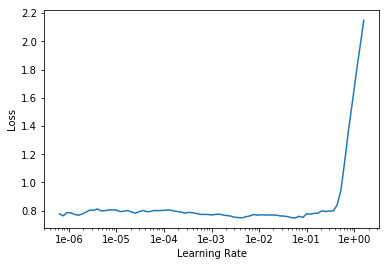

In [153]:
learn.lr_find()
learn.recorder.plot()

In [154]:
learn.fit_one_cycle(5,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.414204,0.444287,0.663749,01:38
1,0.373436,0.342239,0.581981,01:39
2,0.350963,0.331221,0.572028,01:39
3,0.327104,0.320652,0.562712,01:40
4,0.316510,0.315509,0.558475,01:39


In [156]:
# learn.save('stage11')
learn.load('stage11');

7105

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


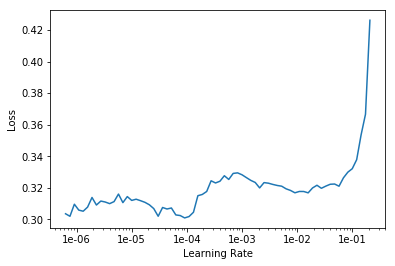

In [159]:
gc.collect()
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

7106

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


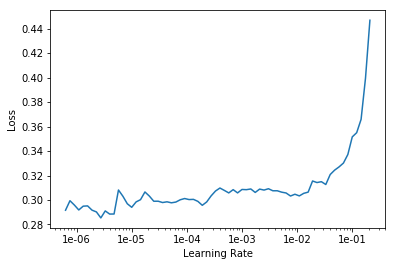

In [158]:
gc.collect()
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [160]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-06,2e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.307631,0.317542,0.560268,03:41
1,0.305616,0.317805,0.560355,03:46


In [103]:
# learn.fit_one_cycle(2,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.397803,0.342961,0.584263,01:19
1,0.335356,0.335299,0.577137,01:20


In [107]:
# learn.save('stage1')
learn.load('stage1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


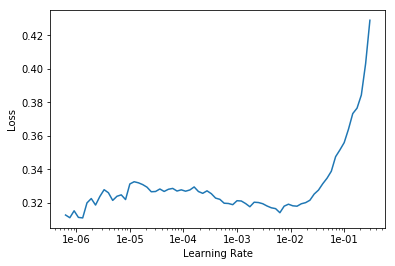

In [108]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [109]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-05,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.320073,0.323405,0.566905,01:34
1,0.312984,0.316634,0.561005,01:36


In [140]:
# learn.save('stage2')
learn.load('stage2');

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


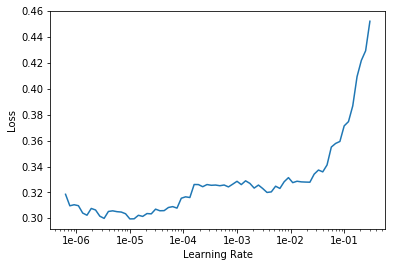

In [134]:
gc.collect()
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

7056

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


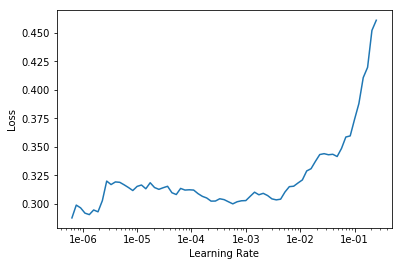

In [135]:
gc.collect()
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [ ]:
#.557

In [141]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-06,8e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.314039,0.315921,0.558846,02:55


In [142]:
# learn.save('stage3')
learn.load('stage3');

30642

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


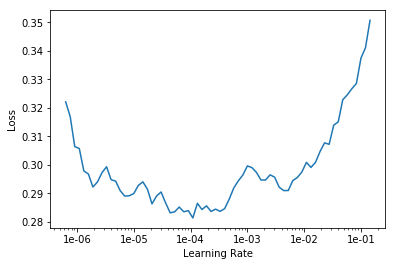

In [144]:
gc.collect()
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

7030

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


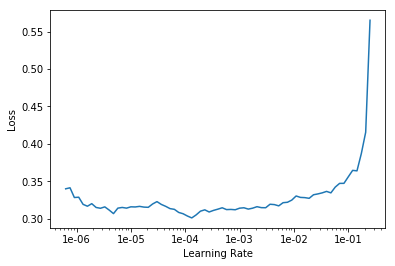

In [145]:
gc.collect()
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [146]:
# learn.unfreeze()
# learn.fit_one_cycle(2, slice(1e-06,1e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.307472,0.316352,0.559316,03:42
1,0.304338,0.314455,0.557607,03:41


In [94]:
# # 2% data
learn.fit_one_cycle(3,max_lr=4e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.401040,0.397983,0.629031,01:19
1,0.348525,0.356270,0.594824,01:21
2,0.314176,0.323454,0.566556,01:20


Better model found at epoch 0 with root_mean_squared_error value: 0.6290311813354492.
Better model found at epoch 1 with root_mean_squared_error value: 0.5948235392570496.
Better model found at epoch 2 with root_mean_squared_error value: 0.5665555596351624.


In [88]:
# # 2% data
# learn.fit_one_cycle(2,max_lr=4e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.394604,0.358882,0.597357,01:19
1,0.329251,0.330154,0.572401,01:20


Better model found at epoch 0 with root_mean_squared_error value: 0.5973573327064514.
Better model found at epoch 1 with root_mean_squared_error value: 0.572400689125061.


In [66]:
# 15% data
# learn.fit_one_cycle(epochs,max_lr=4e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.362606,0.353872,0.592978,02:19
1,0.338322,0.321265,0.564910,02:19


Better model found at epoch 0 with root_mean_squared_error value: 0.5929777026176453.
Better model found at epoch 1 with root_mean_squared_error value: 0.564910352230072.


In [18]:
# learn.model

SequentialMultipleInput(
  (0): MultiBatchMixEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(33781, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(33781, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearTabularTextClassifier(
    (rnn_lin_layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
    )
    (embeds): ModuleList(
      (0): Embedding(11, 6)
      (1): Embedding(112, 22)
      (2): Emb